In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/productdemandforecasting/Historical Product Demand.csv


This notebook is my first attempt at using SARIMA models for time series forecasting.

In [ ]:
# This notebook is based on the notebook Forecast Order Demand and Visualization by Sanjoy Biswas
# https://www.kaggle.com/code/imsanjoykb/forecast-order-demand-and-visualization/notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as ply

In [ ]:
df= pd.read_csv('..kaggle kernels output sandeep1080/storesales-randomforestregressor -p /path/to/dest')

FileNotFoundError: [Errno 2] No such file or directory: '..kaggle kernels output sandeep1080/storesales-randomforestregressor -p /path/to/dest'

Data Exploration

In [ ]:
#check skewness, null values, dtypes, kurtosis, clean the data a little

print(df.isnull().sum()) #null values

#set order demand dtype to numeric
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand']=pd.to_numeric(df['Order_Demand'],errors='coerce')

df['Product_Category'] = df['Product_Category'].str.replace('Category_',"")



#change datetime object type
df['Date']=pd.to_datetime(df['Date'], errors='coerce')

#drop nas
df.dropna(subset=['Date'], inplace=True)
df.dropna(subset=['Order_Demand'], inplace=True)
df.dropna(axis=0, inplace=True)

df['Year']=df['Date'].dt.year
df['Month']=df['Date'].dt.month

print(df.dtypes)

#interpretation - very high kurtosis: very narrow peak, heavy tails, many outliers.
#high skewness: data highly skewed to right- mode is a small value, but the bigger values are quite large

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
Year                         int32
Month                        int32
dtype: object


In [ ]:
#we'll start with 2012 and end with 2016
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

/tmp/ipykernel_18/3371998763.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df['Order_Demand'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


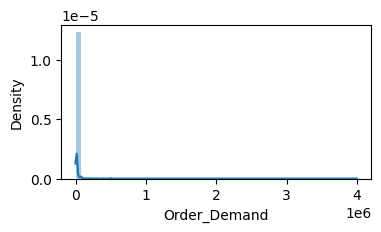

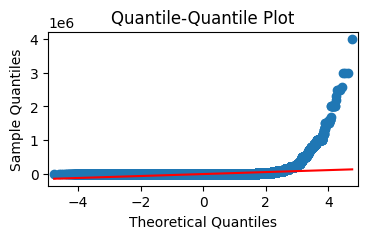

In [ ]:
#check overall distirbution of order demand
rcParams['figure.figsize'] = 4, 2
sb.distplot(df['Order_Demand'])
plt.show()

#get to QQ plot
sm.qqplot(df['Order_Demand'], line='s')  # 's' for standardized line (slope=1, intercept=0)
plt.title('Quantile-Quantile Plot')
plt.show()

In [ ]:
#Univariate analysis
print(df.describe())

print(df['Order_Demand'].skew()) #skewness

print(df['Order_Demand'].kurtosis()) #kurtosis

                                Date  Order_Demand          Year         Month
count                        1036643  1.036643e+06  1.036643e+06  1.036643e+06
mean   2014-06-17 17:36:11.096124672  4.944340e+03  2.013963e+03  6.504678e+00
min              2012-01-01 00:00:00  0.000000e+00  2.012000e+03  1.000000e+00
25%              2013-04-08 00:00:00  2.000000e+01  2.013000e+03  3.000000e+00
50%              2014-06-10 00:00:00  3.000000e+02  2.014000e+03  7.000000e+00
75%              2015-08-26 00:00:00  2.000000e+03  2.015000e+03  1.000000e+01
max              2016-12-30 00:00:00  4.000000e+06  2.016000e+03  1.200000e+01
std                              NaN  2.902137e+04  1.387480e+00  3.444422e+00
31.506080242695006
1871.2341785685655


Time Series Analysis

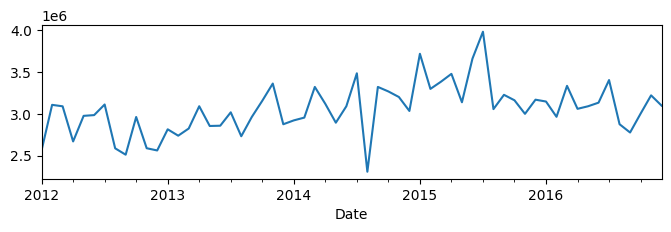

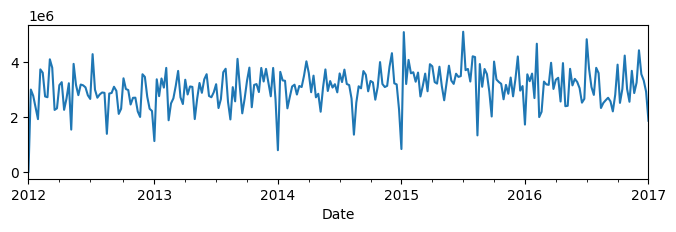

In [ ]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
df = df.set_index('Date')

y = df['Order_Demand'].resample('MS').mean()
y.plot(figsize=(8,2))
plt.show()

w = df['Order_Demand'].resample('W').mean()
w.plot(figsize=(8,2))
plt.show()

# interpretation: overall sales have increased over the years.
# the sales at the beginning of the year is always low, and the peak occurs somewhere in the second half of the year
# Also, weekly data illustrates the seasonality much better than monthly data, but we'll work wit monthly data as handling large lag values in weekly data is more difficult

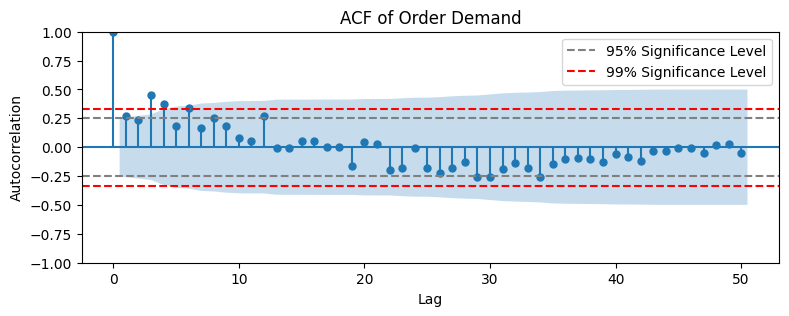

In [ ]:
#ACF Plot
crit_val_95 = 1.96 / (len(y)**0.5)  # For 95% confidence interval
crit_val_99 = 2.58 / (len(y)**0.5)  # For 99% confidence interval

fig, ax = plt.subplots(figsize=(9, 3))
plot_acf(y, ax=ax, lags=50,alpha=0.05)

ax.axhline(y=crit_val_95, linestyle='--', color='gray', linewidth=1.5, label='95% Significance Level')
ax.axhline(y=-crit_val_95, linestyle='--', color='gray', linewidth=1.5)
ax.axhline(y=crit_val_99, linestyle='--', color='red', linewidth=1.5, label='99% Significance Level')
ax.axhline(y=-crit_val_99, linestyle='--', color='red', linewidth=1.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Order Demand')
plt.legend()
plt.show()

#INTERPRETATION:
# Spikes at lag of multiples of 3 suggest quarterly seasonality, with m = 3. We will need to use a SARIMA model
# Now, ideally the ARIMA model should take m=3 as the seasonal period, but it performs wayy better when m is taken to be 12.
# Why?? I don't understand

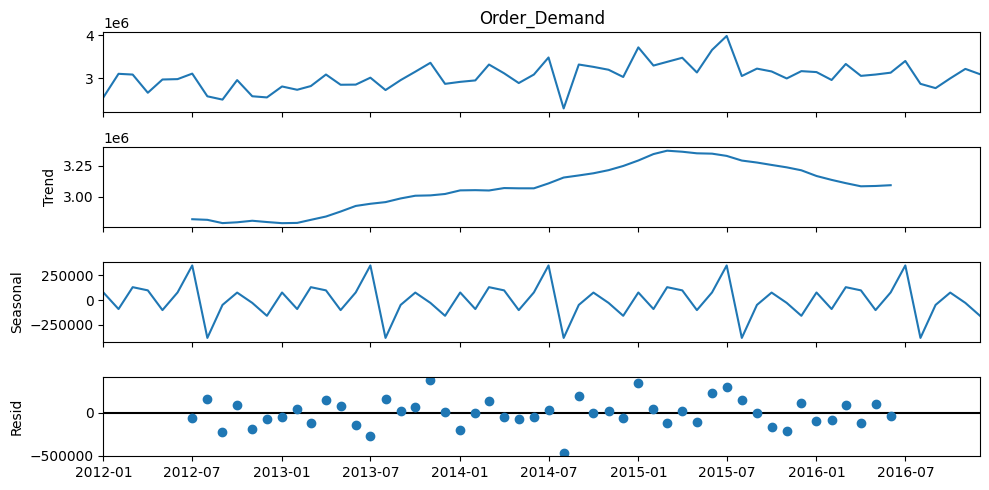

In [ ]:
#classical time series decomposition
decomposition = sm.tsa.seasonal_decompose(y, model='additive',period=12)
rcParams['figure.figsize'] = 10,5
fig = decomposition.plot()
plt.show()

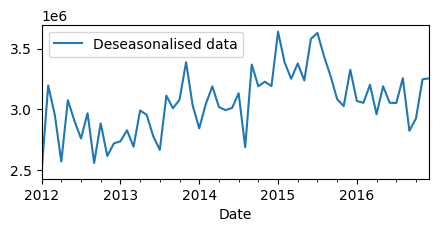

In [ ]:
#now we'll deseasonalise data to visually estimate p, q , r
seasonal = decomposition.seasonal
deseasonalised_data = y - seasonal
deseasonalised_data.plot(figsize=(5,2), label = 'Deseasonalised data')
plt.legend()
plt.show()

ADF:-10.29236261391481
pvalue:3.542746312766812e-18


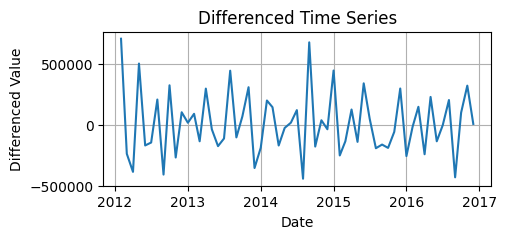

In [ ]:
# DETERMINING d
#Our time series also had an evident trend.
#We'll use the ADF test to determine how many degrees of differencing is sufficient to make it stationary

diff_1st = deseasonalised_data.diff()
adf, pvalue, _,_,_,_=adfuller(diff_1st.dropna())
print(f'ADF:{adf}')
print(f'pvalue:{pvalue}')

plt.figure(figsize=(5, 2))
plt.plot(diff_1st.dropna())
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.show()

#Interpretation: The pvalue of the 1st order differenced series is well below 0.05.
# => d=1 is enough as 1st order differencing yields a stationary ts

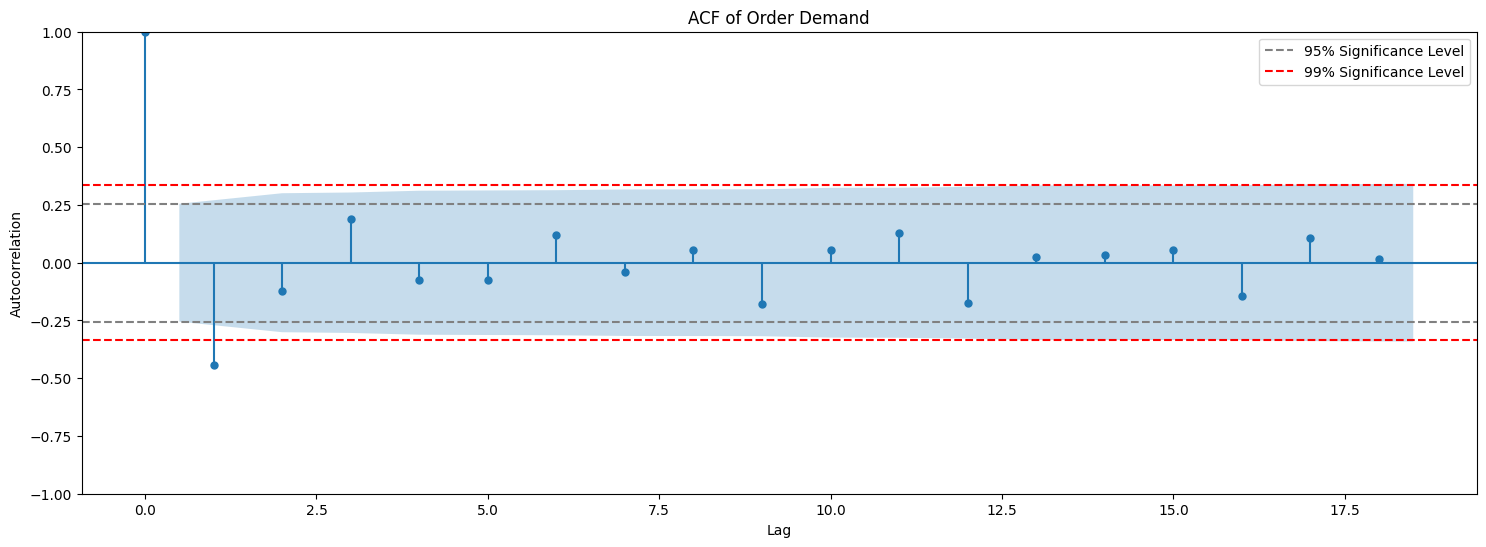

In [ ]:
# DETERMINING q
# ACF plot for demand data

diff_1st = diff_1st.dropna()
crit_val_95 = 1.96 / (len(diff_1st)**0.5)  # For 95% confidence interval
crit_val_99 = 2.58 / (len(diff_1st)**0.5)  # For 99% confidence interval

fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(diff_1st, ax=ax, alpha=0.05)

ax.axhline(y=crit_val_95, linestyle='--', color='gray', linewidth=1.5, label='95% Significance Level')
ax.axhline(y=-crit_val_95, linestyle='--', color='gray', linewidth=1.5)
ax.axhline(y=crit_val_99, linestyle='--', color='red', linewidth=1.5, label='99% Significance Level')
ax.axhline(y=-crit_val_99, linestyle='--', color='red', linewidth=1.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Order Demand')
plt.legend()
plt.show()

#INTERPRETATION: ACF drops close to 0 at 2. Thus q = 2


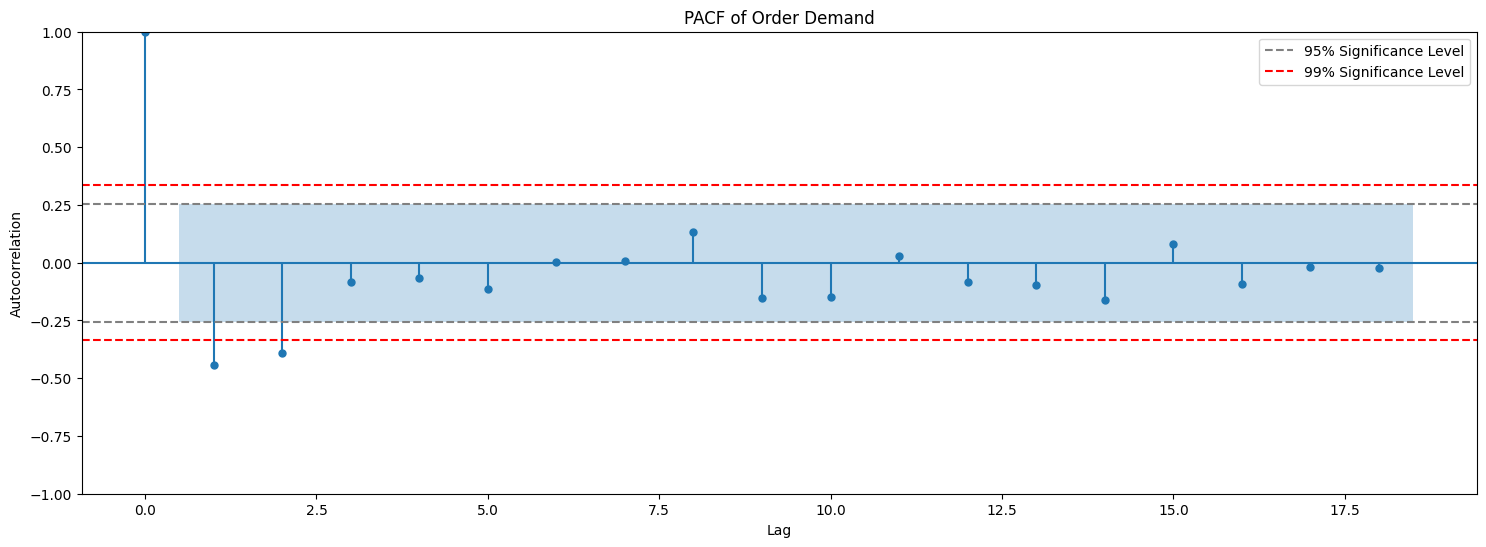

In [ ]:
# DETERMINING p

crit_val_95 = 1.96 / (len(diff_1st)**0.5)  # For 95% confidence interval
crit_val_99 = 2.58 / (len(diff_1st)**0.5)  # For 99% confidence interval

fig, ax = plt.subplots(figsize=(18, 6))
plot_pacf(diff_1st, ax=ax)

ax.axhline(y=crit_val_95, linestyle='--', color='gray', linewidth=1.5, label='95% Significance Level')
ax.axhline(y=-crit_val_95, linestyle='--', color='gray', linewidth=1.5)
ax.axhline(y=crit_val_99, linestyle='--', color='red', linewidth=1.5, label='99% Significance Level')
ax.axhline(y=-crit_val_99, linestyle='--', color='red', linewidth=1.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('PACF of Order Demand')
plt.legend()
plt.show()

# Interpretation: the first two lag values have significant PACF. Thus, p can be taken to be 3. p=3

In [ ]:
# Grid Search for parameter tuning
# We will try all combinations within this range to find the best parameters for this model
import itertools
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
d = range(0,2)
p = range(0,4)
q = range(0,3)
P = D = Q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(y,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results = model.fit(disp=False)
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            # If there's an error, continue to the next parameter combination
            print(f"Error for SARIMA{param}x{param_seasonal}: {str(e)}")

            continue


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.927583212436
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3071.528024456278
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457734
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859483
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3125.6813593306265
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.087487804522
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700705
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345489
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2988.5628301644883
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650909
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277812
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759124
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3070.4334214018813
SARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:1822.579715090896
SARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC

In [ ]:
# best parameters are (3, 1, 0)x(1, 1, 0, 12) with AIC = 906.8
model = SARIMAX(y,
                order=(3, 1, 0),
                seasonal_order=(1, 1, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7301      0.187     -3.900      0.000      -1.097      -0.363
ar.L2         -0.4354      0.262     -1.663      0.096      -0.949       0.078
ar.L3         -0.0831      0.243     -0.342      0.732      -0.559       0.392
ar.S.L12      -0.4514      0.255     -1.773      0.076      -0.951       0.048
sigma2      9.695e+10    6.4e-13   1.51e+23      0.000     9.7e+10     9.7e+10


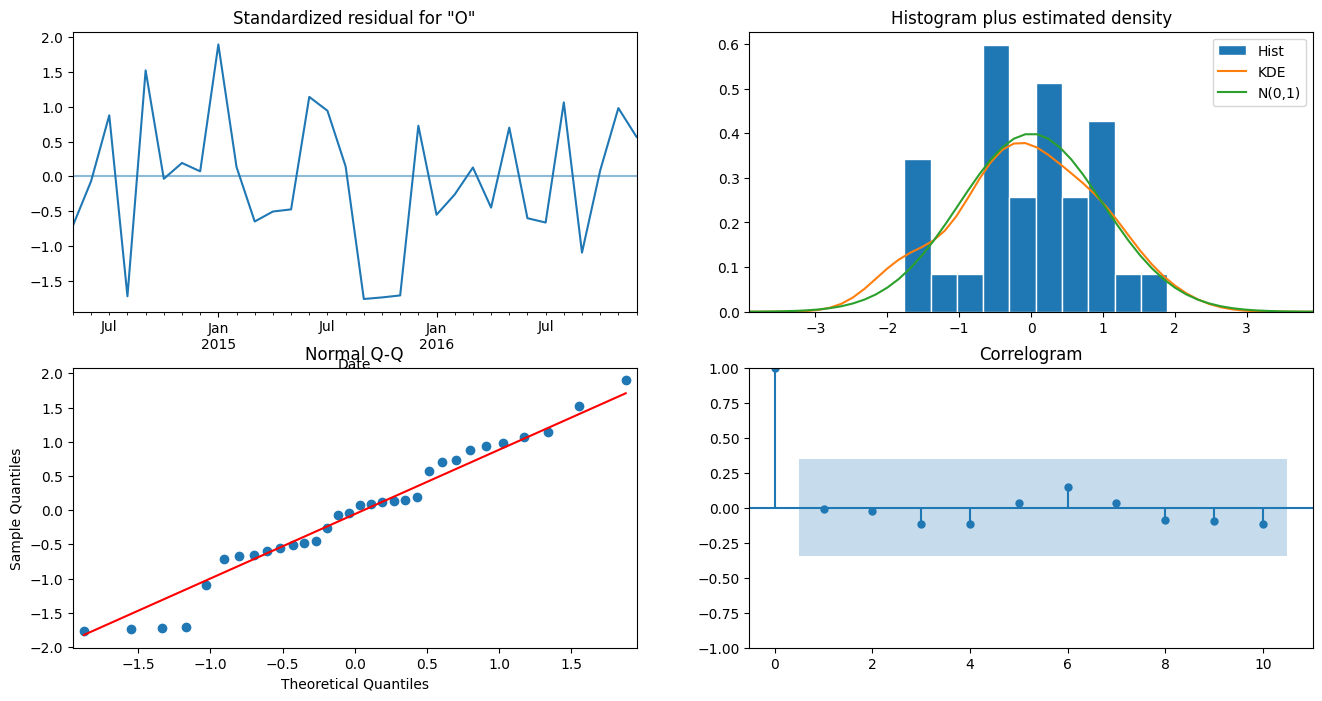

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#INTERPRETATION:
# residuals are normally distributed
# residuals look like white noise
# no significant ACF between residuals
# this looks like a decent model

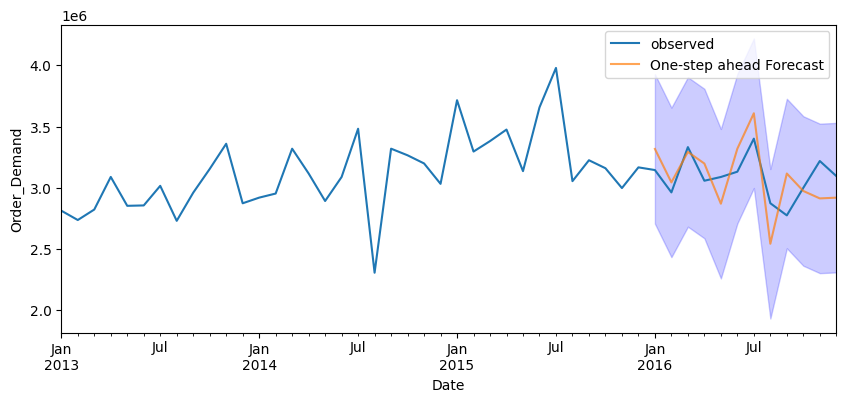

In [ ]:
# Let's get predicting!

pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()


In [ ]:
#get MSE
forecasted = pred.predicted_mean
true_values = y['2016-01-01':]
mse = ((forecasted-true_values)**2).mean()
print(f'MSE = {mse}')
print(f'RMSE = {np.sqrt(mse)}')

MSE = 44556040660.02724
RMSE = 211083.0184075148


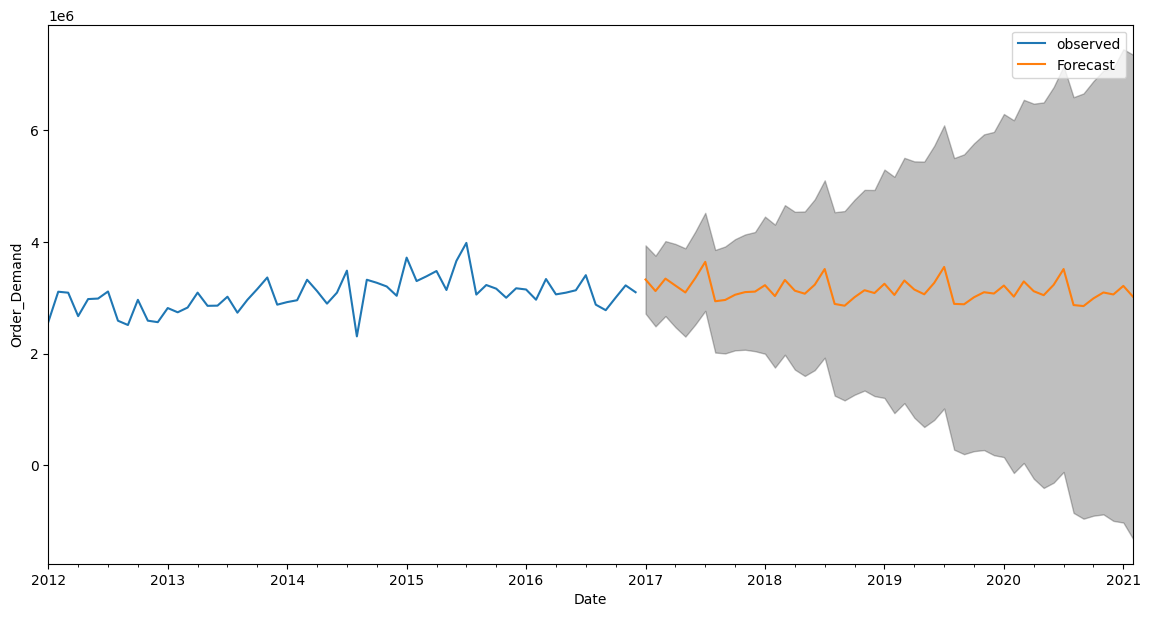

In [ ]:
#prediction confidence interval

predictions = results.get_forecast(steps=50)
conf_intervals = predictions.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
predictions.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(conf_intervals.index,
                conf_intervals.iloc[:, 0],
                conf_intervals.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()
